In [157]:
%matplotlib inline
import pickle
import seaborn as sns

from numpy import cos, sin
from scipy.stats import rv_continuous, kstest 
from numpy.linalg import norm
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from IPython.display import clear_output
from typing_extensions import Literal

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim.lr_scheduler import ExponentialLR
from diffusers import DDPMScheduler, UNet1DModel


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
R_earth = 6400000.
R_moon = 1737100.
dist_moon = 380000000.
R_m = 16 * R_earth
b = 5 * R_earth
phi_ecl = np.pi / 36
cos_ecl = cos(phi_ecl)
sin_ecl = sin(phi_ecl)
g_10 = -29404.8 * 1e-9
g_11 = -1450.9 * 1e-9
h_11 = 4652.5 * 1e-9 
k_b = 1.38e-23
q = 1.6e-19 #Кл
m = 1.67e-27 #Кг
c = 3e8 #м/с
mu_0 = 4*np.pi * 1e-7 # Гн/м
m_x = 4*np.pi*R_earth**3 / mu_0 * g_11
m_y = 4*np.pi*R_earth**3 / mu_0 * h_11
m_z = 4*np.pi*R_earth**3 / mu_0 * g_10


maxiter = 10000
# B_imf_xyz = np.array([0, 0, -8e-9])
B_imf_xyz = np.array([5e-9, 0, 0])
C_i = 0.1
C_a = 0.5
lambd = 0.15
m_particles = 16*m
q_particles = q

In [13]:
class Probabilities:
    def __init__(self):
        
        self.thetha_np = self.thetha_north_pole(th_up_n, th_down_n, name='thetha_norht_pole', a=th_down_n, b=th_up_n)
        self.phi_np = self.phi_north_pole(name='phi_north_pole', a=0, b=2*np.pi)
        self.thetha_sp = self.thetha_south_pole(th_up_s, th_down_s, name='thetha_south_pole', a=th_down_s, b=th_up_s)
        self.phi_sp = self.phi_south_pole(name='phi_north_pole', a=0, b=2*np.pi)
        self.r_dist = self.R_dist(name='R_dist', a=7*R_earth, b=10*R_earth)
        self.v_t = self.v_thetha(name='v_thetha', a=0, b=2*np.pi)
        self.v_p = self.v_phi(name='v_phi', a=0, b=2*np.pi)
        self.w_dist = self.W_dist(name='R_dist', a=0, b=np.inf)
        self.count = 0
        self.count_behind = 0
        self.n = 1
        self.dep = 1
        self.traj = []
        self.save = []
        self.last_particles = []
        
    @staticmethod
    def w2v(w, m_particles=16*m):
            return c*np.sqrt(1-1/(1+(w*q)/(m_particles*c**2))**2)
    
    def __call__(self):
        try:
            if np.random.randint(2):
                return self.thetha_np.rvs(), self.phi_np.rvs(), self.r_dist.rvs(), self.v_t.rvs(), self.v_p.rvs(), self.w2v(self.w_dist.rvs()*1e3), True  
            return self.thetha_sp.rvs(), self.phi_sp.rvs(), self.r_dist.rvs(), self.v_t.rvs(), self.v_p.rvs(), self.w2v(self.w_dist.rvs()*1e3), False
        except:
            return self.__call__()
        
    class thetha_north_pole(rv_continuous):
        def __init__(self, th_up_n, th_down_n, **kwargs):
            super().__init__(**kwargs) 
            self.th_down_n = th_down_n
            self.th_up_n = th_up_n
        def _pdf(self, x):
            return 1/(self.th_up_n - self.th_down_n)

    class phi_north_pole(rv_continuous):
        def _pdf(self, x):
            return 1/(2*np.pi)

    class thetha_south_pole(rv_continuous):
        def __init__(self, th_up_s, th_down_s, **kwargs):
            super().__init__(**kwargs) 
            self.th_down_s = th_down_s
            self.th_up_s = th_up_s
        def _pdf(self, x):
            return 1/(self.th_up_s - self.th_down_s)

    class phi_south_pole(rv_continuous):
        def _pdf(self, x):
            return 1/(2*np.pi)

    class R_dist(rv_continuous):
        def _pdf(self, x):
            return 1/(3*R_earth)

    class v_thetha(rv_continuous):
        def _pdf(self, x):
            return 1/(2*np.pi)

    class v_phi(rv_continuous):
        def _pdf(self, x):
            return 1/(2*np.pi)

    class W_dist(rv_continuous):
        def _pdf(self, w):
            return 1/3.516 * 1 / (1 + (np.sqrt(w) - 0.82)**2 / (0.76))**(1.5)

In [163]:
with open('b_z_2ntl_0.3_lambda_c_a_0.2.txt', "rb") as f:
    prob = pickle.load(f)

In [116]:
def sph2tor_thetha(thetha, phi, r):
    r1 = np.array([dist_moon*cos(phi), dist_moon*sin(phi), 0])
    r2 = r - r1
    return -r2 @ r1 / norm(r2) / norm(r1)

def download_and_prepare_df(name):
    with open(name, "rb") as f:
        prob = pickle.load(f)
    
    phies = []
    thethas = []
    rs = []
    for last_part in prob.last_particles:
        X, Y, Z = last_part[0], last_part[2], last_part[4] + b
        point_xyz = np.array([X, Y, Z])
        C = np.array([[cos_ecl, 0., -sin_ecl],
                      [0., 1., 0.],
                      [sin_ecl, 0., cos_ecl]])
        new_point = C @ point_xyz
        x, y, z = new_point
        phies += [np.arctan(y / z)]
        thethas += [np.arccos(x / np.sqrt(z**2 + y**2 + x**2))]
        rs += [np.sqrt(X**2 + Y**2 + Z**2)]
        
    v_phies = []
    v_thethas = []
    v = []
    for last_part in prob.last_particles:
        v_x, v_y, v_z = last_part[1], last_part[3], last_part[5]
        point_xyz = np.array([v_x, v_y, v_z])
        C = np.array([[cos_ecl, 0., -sin_ecl],
                      [0., 1., 0.],
                      [sin_ecl, 0., cos_ecl]])
        new_point = C @ point_xyz
        v_x, v_y, v_z = new_point
        v_phies += [np.arctan(v_y / v_z) if x > 0 else np.arctan(v_y / v_z) + np.pi]
        v_thethas += [np.arccos(v_x / np.sqrt(v_z**2 + v_y**2 + v_x**2))]
        v += [np.sqrt(v_x**2 + v_y**2 + v_z**2)]
    
    tor_thetha = []
    for thetha, phi, r in zip(thethas, phies, rs):
        tor_thetha += [sph2tor_thetha(thetha, phi, r)]
        
    # read data
    names = np.array(
        [
            "r",
            "thetha",
            "tor_thetha",
            "phi",
            "vphi",
            "vthetha",
            "lnv",
        ]
    )
    data = pd.DataFrame({"r": rs,
                        "thetha": thethas,
                        "tor_thetha": tor_thetha,
                        "phi": phies,
                        "vphi": v_phies,
                        "vthetha": v_thethas,
                        "lnv": np.log(v)})
    return data, names

In [122]:
data, names = download_and_prepare_df(name="b_z_2ntl_0.3_lambda_c_a_0.2.txt")

In [123]:
X = data[names[2:]].values
# X = np.abs(X)

In [144]:
def plot_hists(X1, names, label1, bins=np.linspace(-3, 3, 61), X2=None, label2=None):
    plt.figure(figsize=(5 * 4, 5 * 2), dpi=500)
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C0")
        if X2 is not None:
            plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C4")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

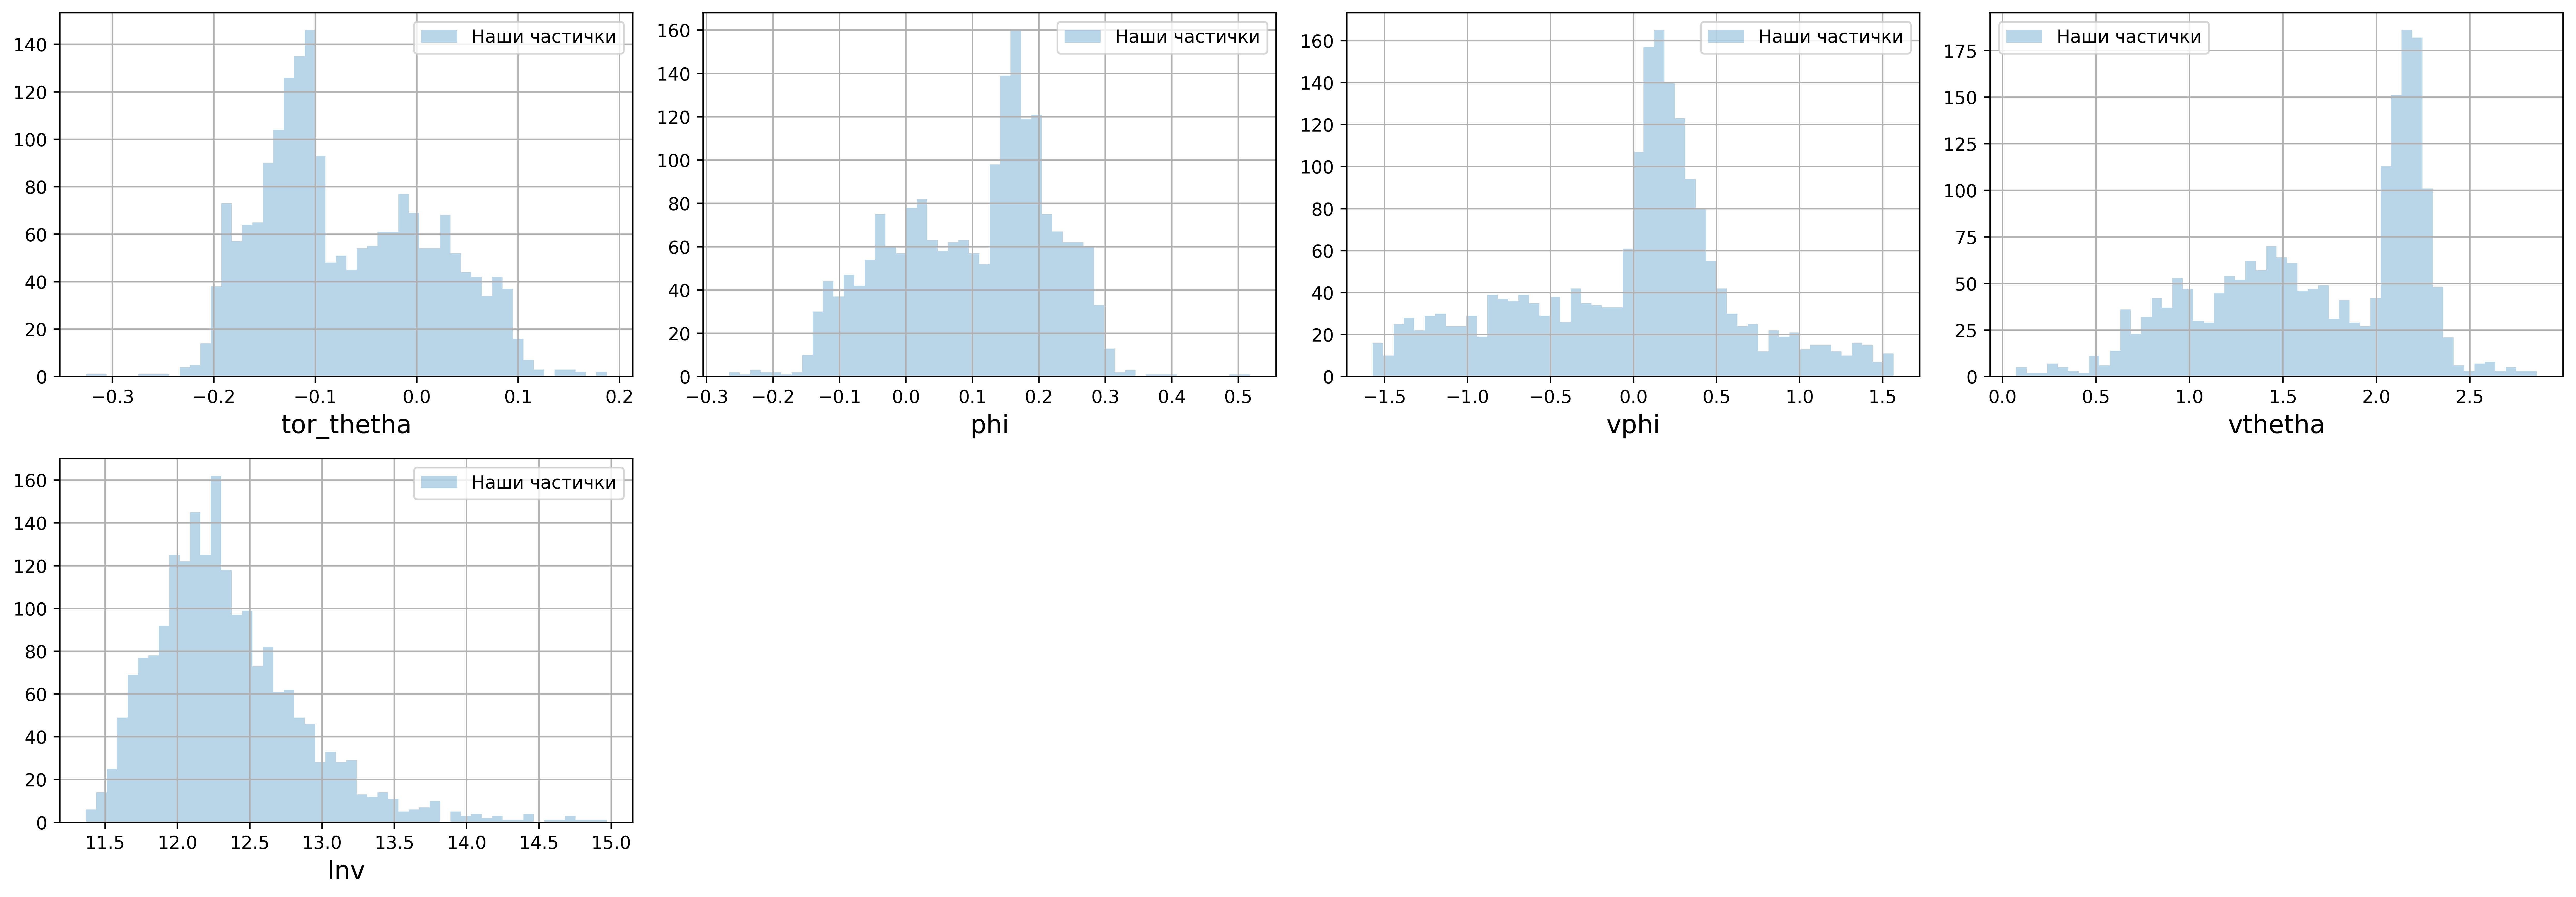

In [145]:
plot_hists(
    X, names[2:], label1="Наши частички", bins=50
)

In [149]:
# from sklearn.model_selection import train_test_split

# # train / test split
# X_train, X_test = train_test_split(
#     X, test_size=0.3, shuffle = True, random_state = 11
# )

In [158]:
qt = QuantileTransformer(random_state=0, output_distribution='normal')

X_tf = qt.fit_transform(X_train)
# X_test = qt.transform(X_test)

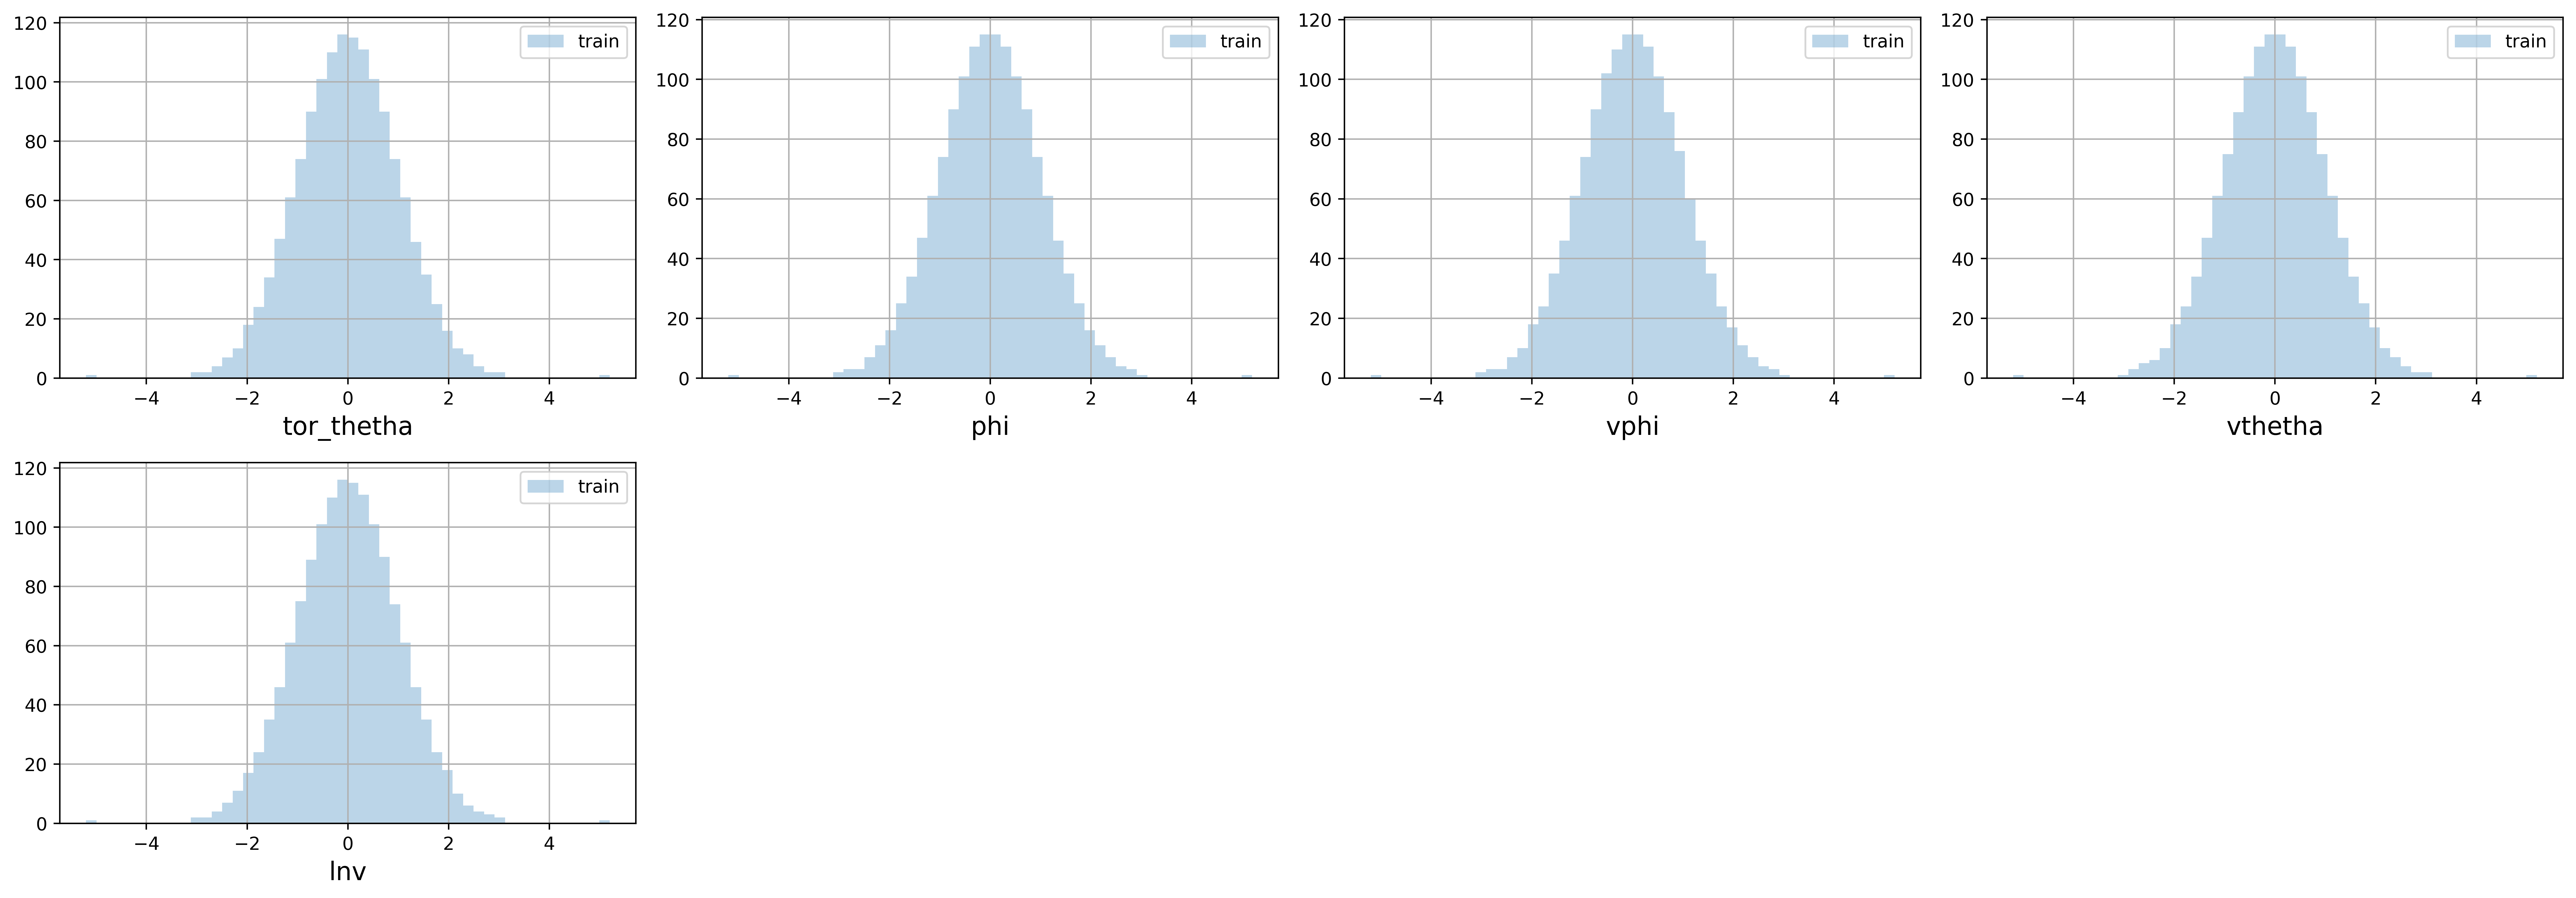

In [160]:
plot_hists(
    X_tf, names[2:], label1="train", bins=50,
#     X2 = X_test, label2='test'
)

In [152]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, t):
        t = t.expand(z.shape[0], 1)
        zt = torch.cat((z, t), dim=1)
        return self.net(zt)

In [153]:
def generate_with_diffusion(model, num_of_examples, latent_dim, sheduler):
    model.eval()
    sample = torch.randn((num_of_examples, latent_dim)).to(DEVICE)
    for i, t in tqdm(enumerate(sheduler.timesteps)):
        with torch.no_grad():
            t = t.to(DEVICE)
            residual = model(sample, t)
        sample = sheduler.step(residual, t, sample).prev_sample
    return sample

In [154]:
class MyDataset(Dataset): 
    def __init__(self, inp):
        self.inp = inp
        
    def __len__(self):
        return len(self.inp)
        
    def __getitem__(self, idx):
        return self.inp[idx]
    
def batch_collate_fn(batch):    
    return batch

In [155]:
loss_fn = nn.MSELoss()

In [ ]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        noise_scheduler,
        optimizer,
        scheduler,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        sheduler_steps = 5
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.noise_scheduler = noise_scheduler
        self.lr = lr
        self.sheduler_steps = sheduler_steps

        self.opt_gen = optimizer
        self.scheduler = scheduler

        self.model.to(DEVICE)

    def fit(self, X):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = MyDataset(X_real)

        # Turn on training
        self.model.train(True)

        self.loss_history = []
        self.p_values = []
        self.stats = []

        # Fit GAN
        for i, epoch in enumerate(range(self.n_epochs)):
            loss_epoch = 0
            for j, x_batch in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True, collate_fn=batch_collate_fn)
            ):
                
                noise = torch.randn_like(x_batch).to(DEVICE)
                timesteps = torch.randint(0, self.noise_scheduler.num_train_timesteps, (x_batch.shape[0], 1)).long().to(DEVICE)
                noisy_x = self.noise_scheduler.add_noise(x_batch, noise, timesteps).to(DEVICE)
                pred = self.model(noisy_x, timesteps)

                loss = loss_fn(pred, noise)

                # Backprop and update the params:
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()
                
                loss_epoch += loss.item()
                
            if i % self.sheduler_steps == 1:
                self.scheduler.step()

            # caiculate and store loss after an epoch
            
            self.loss_history.append(loss_epoch / (j + 1))
            
            self.model.train(False)
            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score
            legnth = 1000
            X_fake = generate_with_diffusion(self.model, legnth, self.latent_dim, self.noise_scheduler).to(DEVICE)
            
            stat, p_value = kstest(X_fake, X_real)
            self.p_values += [p_value]
            self.stats += [stat]
            
            clear_output(wait=True)  
            
             plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.xlabel("Epoch Number")
            plt.ylabel("Smirnov-Kolmogorov score")
            plt.grid()
            plt.plot(self.stats)

            plt.subplot(1, 3, 2)
            plt.xlabel("Epoch Number")
            plt.ylabel("p-value of Smirnov-Kolmogorov")
            plt.plot(self.p_values, color="orange")
            plt.grid()
            
            plt.subplot(1, 3, 3)
            plt.xlabel("Epoch Number")
            plt.ylabel("Loss")
            plt.plot(self.loss_history, color="purple")
            plt.grid()
            
            plt.show()
            
            self.model.train(True)
        # Turn off training
        self.model.train(False)

In [ ]:
%%time
latent_dim = 10
lr=1e-4
sheduler_steps = 10

model = DiffusionGenerator(n_inputs=latent_dim + 1, n_outputs=X_train.shape[1]).to(DEVICE)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample_range=4)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.9)

diffusionFitter = DiffusionFitter(
    model,
    noise_scheduler,
    optimizer,
    scheduler,
    batch_size=150,
    n_epochs=200,
    latent_dim=latent_dim,
    sheduler_steps = sheduler_steps
)
diffusionFitter.fit(X_tf)